# Modelo

In [102]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import holidays
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Lectura de datos y feature engineeing

In [103]:
Monterrey = pd.read_csv("Files/Datos_2022_2023_CENTRO_limpios.csv", parse_dates=[0], index_col = "date")
daily_Monterrey = Monterrey.resample('D').mean()

# Rango de años
years = range(2022, 2024)

# Crear una lista vacía para almacenar las fechas festivas
festivos = []

# Obtener los días festivos de México
mx_holidays = holidays.Mexico(years=years)

# Llenar la lista con los días festivos y sus nombres
for date, name in mx_holidays.items():
    festivos.append([date, name])

# Crear un DataFrame con las fechas y nombres de los días festivos
festivos_df = pd.DataFrame(festivos, columns=['Fecha', 'Evento'])

# Convertir a formato de fecha
festivos_df['Fecha'] = pd.to_datetime(festivos_df['Fecha'])

daily_Monterrey['is_holiday'] = daily_Monterrey.index.isin(festivos_df['Fecha']).astype(int)

# Crear la variable dummy para fines de semana
daily_Monterrey['is_weekend'] = daily_Monterrey.index.weekday.isin([5, 6]).astype(int)


In [104]:
daily_Monterrey.shape

(594, 17)

## Escalamiento 

In [105]:
# Lista de las columnas independientes y la columna objetivo (dependiente)
independent_columns = ["PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]
target_column = "CO"

# Escalar las variables independientes (X) y la variable dependiente (y)
scaler_X = MinMaxScaler(feature_range=(0, 1))  # Para las características predictoras
scaler_y = MinMaxScaler(feature_range=(0, 1))  # Para la variable a predecir

# Ajustar el escalador para las características (X) y las variables a predecir (y)
X_scaled = scaler_X.fit_transform(daily_Monterrey[independent_columns])  # Escalar las columnas independientes
y_scaled = scaler_y.fit_transform(daily_Monterrey[[target_column]])  # Escalar la columna "CO" (variable dependiente)

## Entrenamiento, validación y testeo

In [106]:
# Número de días para testeo y validación
n_test = 31
n_val = 31

# Últimos 31 datos para testeo
X_test = X_scaled[-n_test:]
y_test = y_scaled[-n_test:]

# 31 días anteriores para validación
X_val = X_scaled[-(n_test + n_val):-n_test]
y_val = y_scaled[-(n_test + n_val):-n_test]

# El resto para entrenamiento
X_train = X_scaled[:-(n_test + n_val)]
y_train = y_scaled[:-(n_test + n_val)]

## Modelo

Epoch 1/20


c:\Users\José Antonio\Documents\TEC\Python\Multivariados\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1697 - val_loss: 0.0013
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0565 - val_loss: 0.0443
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0446 - val_loss: 0.0325
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427 - val_loss: 0.0357
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 - val_loss: 0.0344
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0467 - val_loss: 0.0425
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0438 - val_loss: 0.0390
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - val_loss: 0.0460
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 - val_loss: 0.0397
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - val_loss: 0.0472
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0441 - val_loss: 0.0474
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394 - val_loss: 0.0418

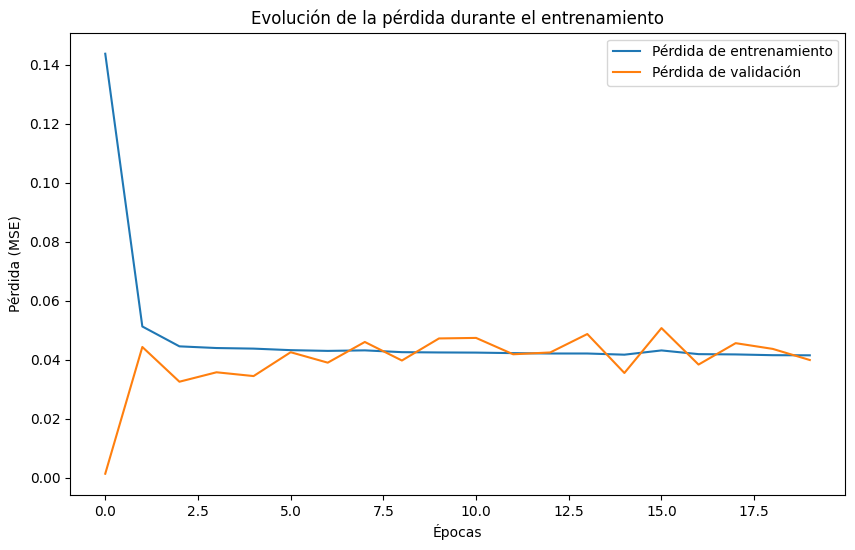

In [107]:
# Reformatear los datos para LSTM (las redes LSTM esperan datos en 3D)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (muestras, pasos de tiempo, características)
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Crear y compilar el modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_val_lstm, y_val))

# Evaluar el modelo en el conjunto de test
loss = model.evaluate(X_test_lstm, y_test)
print(f"Pérdida final en el conjunto de test: {loss}")

# Visualización de la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()

## Predicciones

In [108]:
predictions = model.predict(X_test_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Visualización

In [109]:
# Desescalar las predicciones y los valores reales
predictions_original = scaler_y.inverse_transform(predictions)  # Desescalar las predicciones
y_test_original = scaler_y.inverse_transform(y_test)  # Desescalar los valores reales

# Crear un DataFrame con las fechas, los valores reales y las predicciones desescaladas
fechas_test = daily_Monterrey.index[-n_test:]  # Ajusta esto a tu conjunto de fechas
df_predictions = pd.DataFrame({
    'Fecha': fechas_test,
    'Valor Real': y_test_original.flatten(),  # Desescalar y convertir a 1D
    'Predicciones': predictions_original.flatten()  # Desescalar y convertir a 1D
})
df_predictions.set_index('Fecha', inplace=True)

# Graficar los resultados usando Plotly
fig = go.Figure()

# Graficar los valores reales
fig.add_trace(go.Scatter(
    x=df_predictions.index,
    y=df_predictions['Valor Real'],
    name='Valor Real',
    mode='lines',
    line=dict(color='blue')
))

# Graficar las predicciones
fig.add_trace(go.Scatter(
    x=df_predictions.index,
    y=df_predictions['Predicciones'],
    name='Predicciones',
    mode='lines',
    line=dict(color='red', dash='dash')
))

# Configuración de la gráfica
fig.update_layout(
    title='Comparación entre Predicciones y Valores Reales (Escala Original)',
    xaxis_title='Fecha',
    yaxis_title='Valor CO',
    template='plotly_dark',
    legend=dict(x=0.8, y=0.9)
)

# Mostrar la gráfica
fig.show()